# Welding Experiment Design

In [1]:
# if the package is not installed in your python environment, run this to execute the notebook directly from inside the GitHub repository
%cd -q ..

In [2]:
# enable interactive plots on Jupyterlab with ipympl and jupyterlab-matplotlib installed
# %matplotlib widget

This tutorial will show a slightly more advanced use case example of how to combine different possibilities and do some calculations and analysis with the tools provided by `weldx`.

The tasks covered are the following:

- create a linear weld seam
- add a simple (linear) welding trace along the weld seam
- create two different groove profiles that vary along the weld seam
- generate interpolated pointcloud data from the resulting workpiece
- add two more complex TCP movements:
  - a horizontal weaving motion
  - a vertical weaving motion
- calculate and plot the minimal distance between the the workpiece geometry and the different TCP movements along the entire weld seam

## Python imports

In [3]:
# some python imports that will be used throughout the tutorial
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import pint
import xarray as xr
from mpl_toolkits.mplot3d import Axes3D

In [4]:
# importing the weldx package with prevalent default abbreviations
import weldx
import weldx.geometry as geo
import weldx.utility as ut
from weldx import Q_
from weldx.transformations import LocalCoordinateSystem as LCS
from weldx.welding.groove.iso_9692_1 import get_groove

## helper function
We define small helper function that will calculate the minimal (Euclidean) distance between a point in space (our current TCP position) and a 3d pointcloud that describes our workpiece geometry.

Keep in mind that this is a very simple function that works only on generated point data without any meshing or interpolation. Results will be more accurate for denser point clouds with many points.

In [5]:
def distance(ptc, lcs_name, time):
    """Calculate minimal distance between geometry rasterization pointcloud and 3D trace"""

    lcs_interp = csm.get_cs(
        coordinate_system_name=lcs_name, reference_system_name="workpiece", time=time
    )

    trace = lcs_interp.coordinates.data

    ptc = ptc.T

    ptc = np.expand_dims(ptc, 1)
    trace = np.expand_dims(trace, 0)

    return np.min(np.sqrt(np.sum((ptc - trace) ** 2, axis=-1)), axis=0)

## Trace and CSM setup

Lets define the timestamps that we will use to visualize our experiment:

In [6]:
time = pd.timedelta_range("0s", "10s", freq="50ms")

For this example we will be working with a linear weld seam of 100 mm .

In [7]:
# define the weld seam length in mm
seam_length = Q_(100, "mm")

trace_segment = geo.LinearHorizontalTraceSegment(seam_length)
trace = geo.Trace(trace_segment)

We set up the following coordinate systems:
- the default `base` system
- a `workpiece` system that corresponds to the baseline of our workpiece
- a `tcp_wire` system that represents the very simple case of moving along the weld seam 2 mm above the `workpiece` system with a weld speed of 10 mm/s

In [8]:
# crete a new coordinate system manager with default base coordinate system
csm = weldx.transformations.CoordinateSystemManager("base")

In [9]:
# add the workpiece coordinate system
csm.add_cs(
    coordinate_system_name="workpiece",
    reference_system_name="base",
    lcs=trace.coordinate_system,
)

In [10]:
tcp_start_point = Q_([0.0, 0.0, 2.0], "mm")
tcp_end_point = np.append(seam_length, Q_([0, 2.0], "mm"))

v_weld = Q_(10, "mm/s")
s_weld = (tcp_end_point - tcp_start_point)[0]  # length of the weld
t_weld = s_weld / v_weld

t_start = pd.Timedelta("0s")
t_end = pd.Timedelta(str(t_weld.to_base_units()))

coords = [tcp_start_point.magnitude, tcp_end_point.magnitude]

tcp_wire = LCS(coordinates=coords, time=[t_start, t_end])

# add the workpiece coordinate system
csm.add_cs(
    coordinate_system_name="tcp_wire",
    reference_system_name="workpiece",
    lcs=tcp_wire,
)

### add weaving motions
We now want two define and add two different weaving motions, one in y-direction (towards the groove sidewalls) and another on in z-direction (up and down).
#### add y weaving

In [11]:
sine_y = ut.sine(f=Q_(1, "Hz"), amp=Q_([[0, 1, 0]], "mm"))
coords = ut.lcs_coords_from_ts(sine_y, time)
csm.add_cs(
    coordinate_system_name="tcp_sine_y",
    reference_system_name="tcp_wire",
    lcs=LCS(coordinates=coords),
)

#### add z weaving

In [12]:
sine_z = ut.sine(f=Q_(1, "Hz"), amp=Q_([[0, 0, 2]], "mm"), bias=Q_([0, 0, 0], "mm"))
coords = ut.lcs_coords_from_ts(sine_z, time)
csm.add_cs(
    coordinate_system_name="tcp_sine_z",
    reference_system_name="tcp_wire",
    lcs=LCS(coordinates=coords),
)

Let's visualize the different coordinate systems.

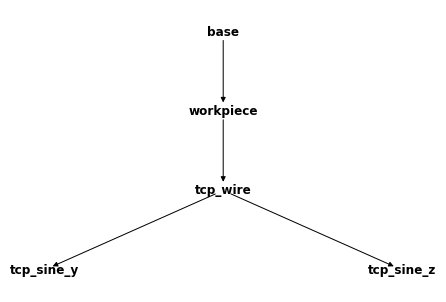

In [13]:
csm

## generate I-Groove pointcloud
Let's finish the workpiece creation by adding groove profiles to the start end end of the welding trace.

For the first example we will use I-Groove profiles and have the root gap open up along the weld seam from 2 mm to 6 mm.

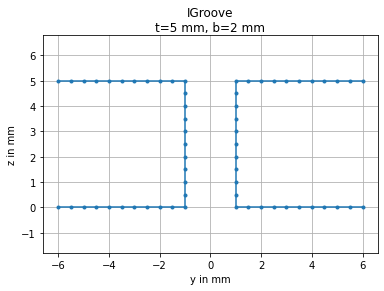

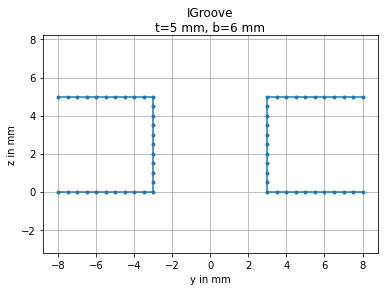

In [14]:
groove_1 = get_groove(
    groove_type="IGroove",
    workpiece_thickness=Q_(5, "mm"),
    root_gap=Q_(2, "mm"),
)

groove_2 = get_groove(
    groove_type="IGroove",
    workpiece_thickness=Q_(5, "mm"),
    root_gap=Q_(6, "mm"),
)

display(groove_1)
display(groove_2)

In [15]:
v_profile = geo.VariableProfile(
    [groove_1.to_profile(), groove_2.to_profile()],
    [0, 100],
    [geo.linear_profile_interpolation_sbs],
)

# create 3d workpiece geometry from the groove profile and trace objects
geometry = geo.Geometry(profile=v_profile, trace=trace)
pointcloud_I = geometry.rasterize(
    profile_raster_width=Q_(1, "mm"), trace_raster_width=Q_(0.5, "mm")
)

## Calculate distance (simple trace in I-Groove center)
The first analysis example is very simple and used to check if our tools work as expected.

If the wire TCP moves on a straight line along the groove center, the distance to the workpiece geometry is equivalent to the distance of each sidewall to the groove center. Since the root gap of the groove changes linearly from 2 mm to 6 mm, we expect the distance to change from 1 mm to 3 mm accordingly.

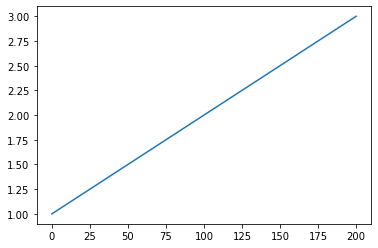

In [16]:
d = distance(pointcloud_I, "tcp_wire", time=time)
plt.plot(d)

## Calculate distance (y-weaving in I-Groove)
Now let's analyze the distance when weaving along the y-axis (towards the sidewalls).
We can see the expected superposition of the weaving motion with the opening of the root gap.
Note the doubling of the observed frequency with regards to the weaving frequency of 1 Hz because we calculate the minimum distance instead of the distance to each sidewall separately.

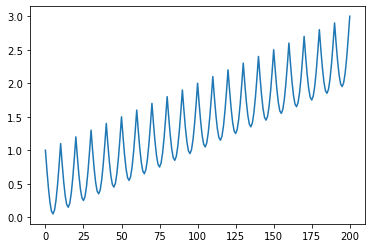

In [17]:
d = distance(pointcloud_I, "tcp_sine_y", time=time)
plt.plot(d)

If we analyze the weaving motion in z-direction alongside the I-Groove, we see no change in distance depending on the z-Position as expected.
The small disturbances are due to the coarse rasterisation of the workpiece geometry.

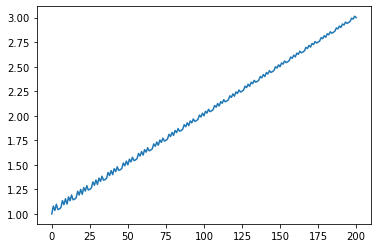

In [18]:
d = distance(pointcloud_I, "tcp_sine_z", time=time)
plt.plot(d)

## Generate V-Groove geometry
Lets look a more complex interaction of groove shapes and TCP motion.

For this example we define two V-Groove profiles that begin at a groove angle of 60 degree with a root face and root gap of 1 mm each. At the end of the weld seam thee groove shape changes to a steep 20 degree angle with a root gap and root face of 3 mm.

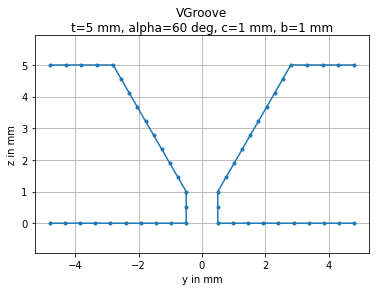

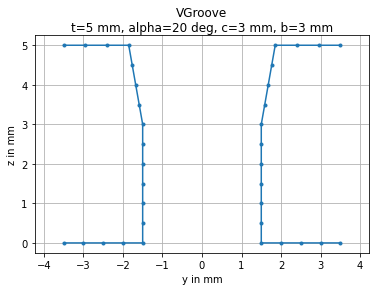

In [19]:
groove_1 = get_groove(
    groove_type="VGroove",
    workpiece_thickness=Q_(5, "mm"),
    groove_angle=Q_(60, "deg"),
    root_face=Q_(1, "mm"),
    root_gap=Q_(1, "mm"),
)

groove_2 = get_groove(
    groove_type="VGroove",
    workpiece_thickness=Q_(5, "mm"),
    groove_angle=Q_(20, "deg"),
    root_face=Q_(3, "mm"),
    root_gap=Q_(3, "mm"),
)

display(groove_1)
display(groove_2)

In [20]:
v_profile = geo.VariableProfile(
    [groove_1.to_profile(), groove_2.to_profile()],
    [0, 100],
    [geo.linear_profile_interpolation_sbs],
)

# create 3d workpiece geometry from the groove profile and trace objects
geometry = geo.Geometry(profile=v_profile, trace=trace)
pointcloud_V = geometry.rasterize(
    profile_raster_width=Q_(0.25, "mm"), trace_raster_width=Q_(0.5, "mm")
)

Now let's look at the CTWD with our previously defined weaving motion in z-direction.

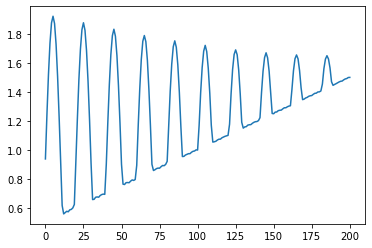

In [21]:
d = distance(pointcloud_V, "tcp_sine_z", time=time)
plt.plot(d)

There are a few things to note:

- as expected, we once again see the linear trend where the root gap opens as a baseline.
- in addition, the distance now consists of two distinct phases:
  - one phase where the TCP is "submerged" into the root face part of the weld. In this case, the distance is not impacted by the z weaving motion
  - the second phase, where the TCP is above the root face and the distance of the V shaped groove section is mimicking the z weaving motion.
- we can also see that the weaving motion reflection is more distinctly discernible if the groove opening angle is large.